1. Loading and Merging Data

In [1]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge customers data with transactions data
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID')

# Preview merged data
merged_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00761,C0199,P022,2024-10-01 05:57:09,4,550.16,137.54,Andrea Jenkins,Europe,2022-12-03
2,T00626,C0199,P079,2024-08-17 12:06:08,2,834.74,417.37,Andrea Jenkins,Europe,2022-12-03
3,T00963,C0199,P008,2024-10-26 00:01:58,2,293.70,146.85,Andrea Jenkins,Europe,2022-12-03
4,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04


2. Feature Engineering

In [2]:
# Calculate total spend by customer
merged_df['TotalSpend'] = merged_df['Quantity'] * merged_df['Price']
customer_features = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalSpend', 'sum'),
    purchase_frequency=('TransactionID', 'count'),
    region=('Region', 'first')  # Assuming the customer region doesn't change
).reset_index()

# Calculate recency (days since last transaction)
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
recency = merged_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (pd.to_datetime('today') - recency['TransactionDate']).dt.days

# Merge recency with customer features
customer_features = pd.merge(customer_features, recency[['CustomerID', 'Recency']], on='CustomerID')

# Display the customer feature set
customer_features.head()

,CustomerID,total_spent,purchase_frequency,region,Recency
0,C0001,3354.52,5,South America,83
1,C0002,1862.74,4,Asia,52
2,C0003,2725.38,4,South America,152
3,C0004,5354.88,8,South America,32
4,C0005,2034.24,3,Asia,81


3. Data Preprocessing (Normalization)

In [3]:
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = customer_features[['total_spent', 'purchase_frequency', 'Recency']]

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Check the normalized features
scaled_features[:5]

array([[-0.06170143, -0.01145819, -0.25718985],
       [-0.87774353, -0.46749414, -0.69547829],
       [-0.40585722, -0.46749414,  0.7183554 ],
       [ 1.03254704,  1.35664965, -0.97824503],
       [-0.78392861, -0.92353008, -0.28546652]])

4. Clustering Algorithm: K-Means

C:\Users\Pranay\miniconda3\envs\tensor_flow\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pranay\miniconda3\envs\tensor_flow\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pranay\miniconda3\envs\tensor_flow\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pranay\miniconda3\envs\tensor_flow\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The defa

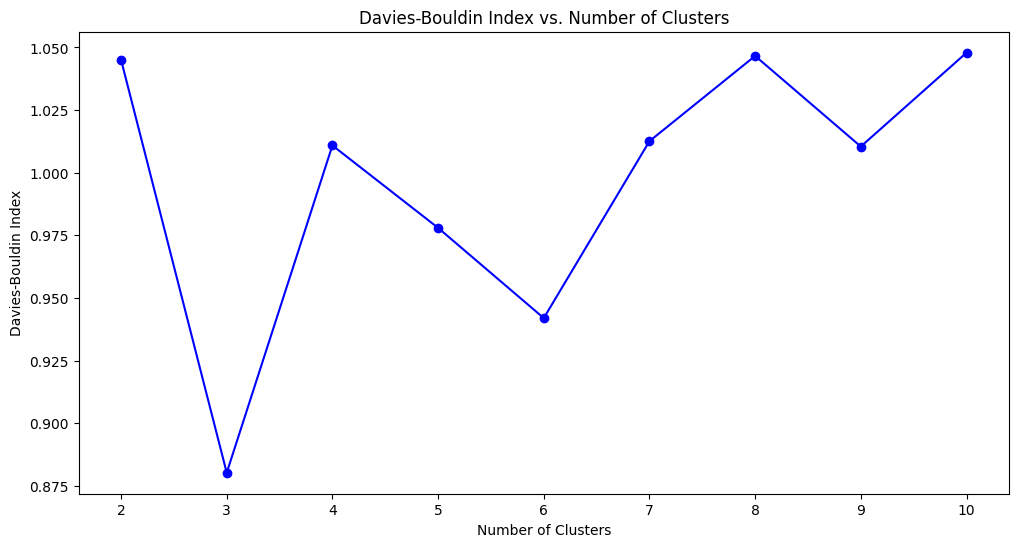

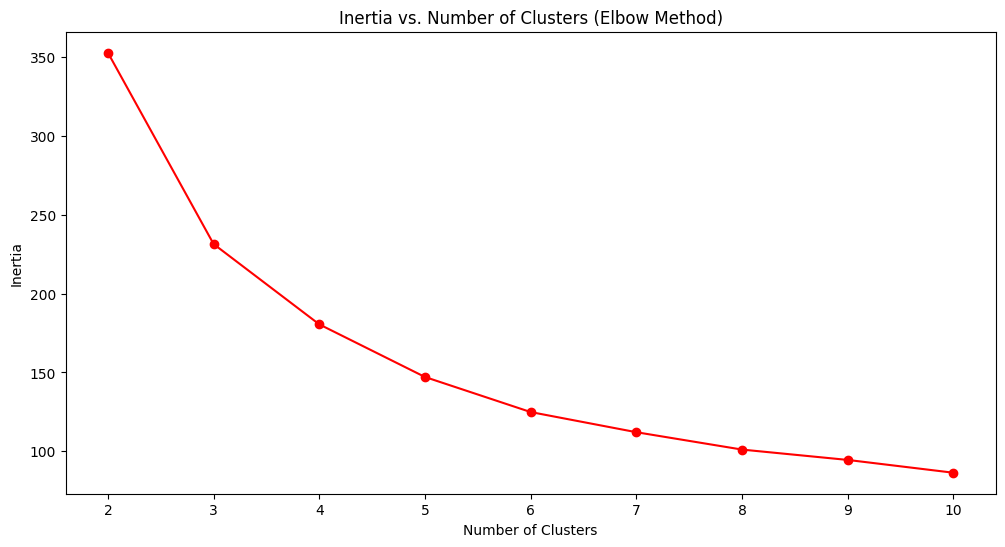

In [4]:
from sklearn.cluster import KMeans
import numpy as np

# Function to calculate the Davies-Bouldin Index (DBI)
from sklearn.metrics import davies_bouldin_score

# K-Means clustering for different values of k (2 to 10 clusters)
inertia = []
dbi_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    
    # Calculate Davies-Bouldin Index (DBI)
    dbi = davies_bouldin_score(scaled_features, kmeans.labels_)
    dbi_scores.append(dbi)
    
    # Store the inertia (sum of squared distances to the nearest cluster center)
    inertia.append(kmeans.inertia_)

# Plot the DB Index and Inertia values for different k values
import matplotlib.pyplot as plt

# Plot DBI vs Number of Clusters
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), dbi_scores, marker='o', color='b')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

# Plot Inertia vs Number of Clusters (Elbow method)
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), inertia, marker='o', color='r')
plt.title('Inertia vs. Number of Clusters (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

6. Final Clustering

In [5]:
# Let's assume the optimal number of clusters is 4 based on the DBI and inertia plots
final_kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(scaled_features)

# Display the final clusters
customer_features[['CustomerID', 'Cluster']].head()

C:\Users\Pranay\miniconda3\envs\tensor_flow\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,CustomerID,Cluster
0,C0001,1
1,C0002,0
2,C0003,0
3,C0004,3
4,C0005,0


7. Visualizing the Clusters

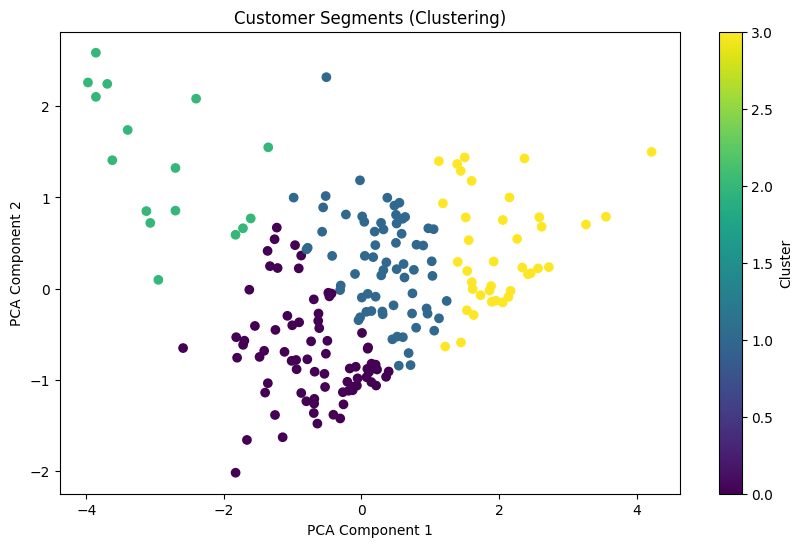

In [6]:
from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Plot the clusters in 2D
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=customer_features['Cluster'], cmap='viridis')
plt.title('Customer Segments (Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()